# Задача
Нейронная сеть: поэкспериментировать с другими простыми фигурами — эллипсом, квадратом, треугольником — повёрнутыми на разные углы (аналитическая геометрия в помощь).

Начнём с эллипса. Зададим его, скажем, полуосями и углом поворота между большой полуосью и осью OX.

In [1]:
import os
import numpy as np
from keras.models import Model, load_model
from keras.layers import Dense, Input
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
def saturate(v):
    return min(1, max(0, v))

import matplotlib.pyplot as plt
def plot_from_model(filename, smooth=False,range=1,d=0.1):
    if(os.path.isfile(filename)):
        model = load_model(filename)
    else:
        print(f"No file found:{filename}")
        return
    %matplotlib inline
    plt.axis('equal')
    plt.rcParams["figure.figsize"] = [16,9]
    
    c = np.r_[-range:range:d]
    # https://stackoverflow.com/a/11144716/539470 =)
    XY = np.transpose([np.tile(c, len(c)), np.repeat(c, len(c))])
    Z = model.predict(XY)
    
    
    if smooth:
        for (x, y), z in zip(XY, Z):
            plt.scatter(x, y, color=[(1, 1-saturate(z[0]), 1-saturate(z[0]))])
    else:
        for (x, y), z in zip(XY, Z):
            plt.scatter(x, y, c='red' if z[0] >= 0.5 else 'green')
    plt.show() 

In [3]:
from math import pi,sin,cos
#Вероятно, это можно оптимизировать через numpy-евское умножение вектора координат на матрицу трансформации,
#просчитанную заранее
def scale(A,a=1,b=1):
    return ((A[0]*a),(A[1]*b))
def rotate(A,angle=0):
    return (A[0]*cos(angle)-A[1]*sin(angle),A[1]*cos(angle)+A[0]*sin(angle))

def inEllipse(A,a=1,b=1,angle=0):
    #a - большая, b-малая, angle - угол поворота в радианах
    B=scale(rotate(A,-angle),1/a,1/b)#Координаты в системе координат эллипса
    #В ней уравнение эллипса имеет простую форму:
    return 1 if B[0]**2+B[1]**2<=1 else 0

def teach_model(X,iters,filename,teacher):
    #teacher - обучающая функция, должна быть (x,y) |--> h(x,y) из [0,1]
    Y=[teacher(a) for a in X]
    l0 = Input(shape=(2,))
    l1 = Dense(6, activation='sigmoid', use_bias=True)(l0)
    l2 = Dense(1, activation='sigmoid', use_bias=False)(l1)

    model = Model(input=l0, output=l2)

    model.compile(
        loss='mean_squared_error',
        optimizer='adam',
        metrics=['accuracy']
    )
    model.fit(
            X, Y,
            epochs=iters,
            verbose=False
        )
    model.save(filename)
def angleToRads(phi):
    return phi/360*2*pi

Для начала попробуем обучать на простой решетке, для нескольких разных углов.

In [4]:
#making a grid

c = np.r_[-2:2:0.2]
#Не брать a больше 2, не меняя границы решетки
# https://stackoverflow.com/a/11144716/539470 =)
grid = np.transpose([np.tile(c, len(c)), np.repeat(c, len(c))])
print(len(c)**2)
grid[0]

400


array([-2., -2.])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


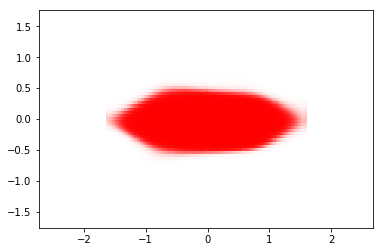

Plot for angle=0 calculated in 20.333035707473755s


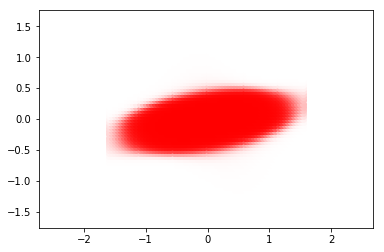

Plot for angle=0.17 calculated in 19.438032627105713s


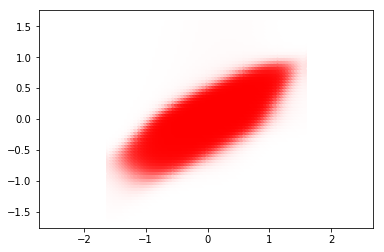

Plot for angle=0.52 calculated in 19.082029581069946s


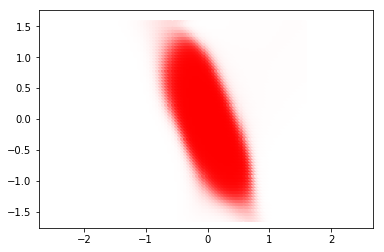

Plot for angle=1.95 calculated in 19.47502827644348s


In [5]:
import time
angles = [0,angleToRads(10),angleToRads(30),angleToRads(111.5)]
a=1.5
b=0.5
for angle in angles:
    sTime=time.time()
    filename = f"models/Ellipse_angle{round(angle,2)}_a{a}_b{b}.h5"
    if(not os.path.isfile(filename)):
        teach_model(grid,5000,filename,lambda A:inEllipse(A,a,b,angle))
    plot_from_model(filename,smooth=True,range=1.6,d=0.05)
    fTime=time.time()
    print(f"Plot for angle={round(angle,2)} calculated in {fTime-sTime}s")

Получается сильно размазанно. Нужны обучающие данные поподробнее.
Можно бы было воспользоваться приёмом, который я применил в 16 задачи - добавить в обучающие данные два эллипса - чуть меньший и чуть больший искомого. Однако мне интересно поиграться с преобразованиями системы координат, поэтому вместо этого я воспользуюсь решеткой, но несколько более подробной и, главное, повернутой и отмасштабированной по эллипсу.
Испытывать будем на последнем эллипсе.

2116
[-1.15 -1.15]
[ 1.   -1.15]
[ 1.16720472 -1.3942321 ]
[-0.01476174  1.60636456]


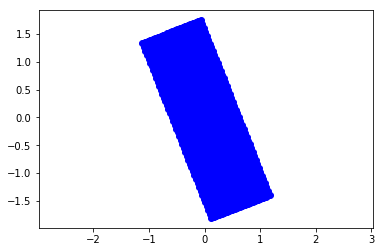

In [6]:
angle = angles[3]
c2 = np.r_[-1.15:1.15:0.05] #Решетка будет выглядеть так в системе координат самого эллипса(где полуоси имеют длину 1)
grid2 = np.transpose([np.tile(c2, len(c2)), np.repeat(c2, len(c2))])
print(len(c2)**2)
print(grid2[0])
print(grid2[43])
#Теперь нужно перевести эту решетку в нашу систему координат. Для этого применим обратное преобразование.
tGrid=np.array([rotate(scale(A,a,b),angle) for A in grid2])
print(tGrid[0])
print(tGrid[43])
%matplotlib inline
plt.axis('equal')
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(tGrid[:,0],tGrid[:,1],'bo')

Сетка выглядит хорошо. Обучим на ней модель:

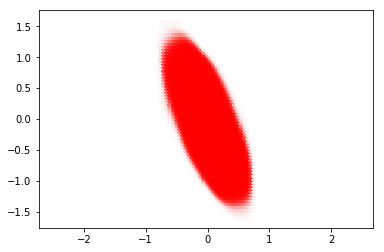

Plot calculated in 21.723243951797485s


In [7]:
sTime=time.time()
filename = f"models/Ellipse_rotGrid_angle{round(angle,2)}_a{a}_b{b}.h5"
if(not os.path.isfile(filename)):
    teach_model(tGrid,5000,filename,lambda A:inEllipse(A,a,b,angle))
plot_from_model(filename,smooth=True,range=1.6,d=0.05)
fTime=time.time()
print(f"Plot calculated in {fTime-sTime}s")

Вот это уже покрасивее.

Наконец, давайте ещё на какую-нибудь фигуру обучим нейросеть - например, прямоугольник.

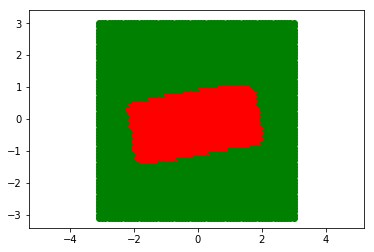

Plot for i=0 calculated in 23.140479803085327s


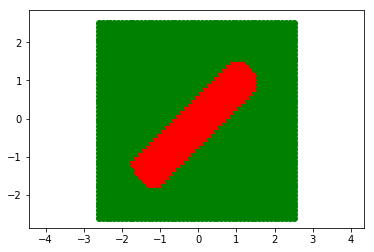

Plot for i=1 calculated in 13.983654260635376s


In [8]:
def inRectangle(A,a,b,angle):
    #Прямоугольник - это повернутый и растянутый квадрат.
    B=scale(rotate(A,-angle),1/a,1/b)
    return 1 if (abs(B[0])<=1 and abs(B[1])<=1) else 0
angles=[angleToRads(10),angleToRads(45)]
As=[2,2]
Bs=[1,0.5]
for i in range(len(angles)):
    angle=angles[i]
    a=As[i]
    b=Bs[i]
    c = np.r_[-1.2:1.2:0.1]
    grid = np.transpose([np.tile(c, len(c)), np.repeat(c, len(c))])
    #Теперь нужно перевести эту решетку в нашу систему координат. Для этого применим обратное преобразование.
    tGrid=np.array([rotate(scale(A,a,b),angle) for A in grid])
    sTime=time.time()
    filename = f"models/Rectangle_angle{round(angle,2)}_a{a}_b{b}.h5"
    if(not os.path.isfile(filename)):
        teach_model(tGrid,10000,filename,lambda A:inRectangle(A,a,b,angle))
    plot_from_model(filename,smooth=False,range=a+b+0.1,d=0.1)
    fTime=time.time()
    print(f"Plot for i={i} calculated in {fTime-sTime}s")